# Predict weather
For renewable generation, predict:
- Irradiance (GHI)
- Temperature
- Wind speed

In [1]:
from platform import python_version
print("Current Python Version-", python_version())
!ls /kaggle/working/darts_logs

Current Python Version- 3.7.12
ls: cannot access '/kaggle/working/darts_logs': No such file or directory


In [2]:
!pip install darts
#!pip install pandas
#!pip install numpy
#!pip install plotly

!pip install pyyaml #==5.4.1 # Google colab

#GPU: https://unit8co.github.io/darts/userguide/gpu_and_tpu_usage.html
#!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

!pip install -U optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.0/592.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 5.1 MB/s eta 0:00:00
  Created wheel for pyod: filename=pyod-1.0.7-py3-none-any.whl size=181102 sha256=d4856348423e6586bdaba5eeaef7cf59a0651ad6c7481ae554e0799d73f2a543
  Stored in directory: /root/.cache/pip/wheels/a4/97/94/6574311546af4d192630d77eacb23eb1b2b9e5b1a87ebea4c7
Successfully built pyod
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 38.3 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency res

In [3]:
import darts as dts
import pandas as pd
import numpy as np
import plotly.express as px
import os

# Import dataset

In [4]:
print("File location using os.getcwd():", os.getcwd())

# default path for local execution on PC
PATH = ""
WORK_DIR = PATH

# if using colab
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  #set path for colab
  PATH = "/content/drive/My Drive/Colab Notebooks/time_series/" #input
  WORK_DIR = PATH #output
  
  #mount like on Linux
  from google.colab import drive
  drive.mount('/content/drive')

if 'kaggle' in str(os.getcwd()):
  PATH = "/kaggle/input/" #input
  WORK_DIR = "/kaggle/working/darts_logs/" #output


df2017 = pd.read_csv(PATH + 'nsrdb-tours/361685_47.41_0.78_2017.csv', skiprows=2)
df2018 = pd.read_csv(PATH + 'nsrdb-tours/361685_47.41_0.78_2018.csv', skiprows=2)
df2019 = pd.read_csv(PATH + 'nsrdb-tours/361685_47.41_0.78_2019.csv', skiprows=2)
#!rm /kaggle/working/state.db #to clean old prediction

File location using os.getcwd(): /kaggle/working


In [5]:
#TODO for Adrien: predict with solar position: https://climlab.readthedocs.io/en/latest/api/climlab.solar.insolation.html

# Data import

In [6]:
# df = pd.read_csv('dataset1_tropical.csv', sep=";")
#df['datetime'] = pd.to_datetime(df['datetime'])

#concatenate in a whole dataset
df = pd.concat([df2017, df2018, df2019])

#genenarate a datetime index column
df['datetime'] = pd.to_datetime(df['Year'].astype(str) +'-' 
                                + df['Month'].astype(str) 
                                + '-' + df['Day'].astype(str) 
                                + ' ' + df['Hour'].astype(str) 
                                + ':' + df['Minute'].astype(str) + ':00'
                                )

#set datetiem as index
df = df.set_index('datetime')

#drop useless columns
df = df.drop(['Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1)

# accelerate processing by reducing information
df = df.astype(np.float32)

# Set constants

In [7]:
n_DATA = len(df)//3 #lenght of one year

N_DAY = 24 * 4 #number of slots in a day
N_HOURS = 23 # from 0 to 23 hour in day
N_MINS = 45 # from 0 to 45 min in hour

# Data analysis

In [8]:
#df.info() # check dataframe info
#df.isnull().sum()  # check missing value

In [9]:
# plot one year of data
#fig = px.line(df.loc['2017-1-1':'2017-12-31'])
#fig.show()

In [10]:
# # proccess average on value
# frequency = pd.Timedelta('15 min') # set frequency
# df_resampled = df.resample(frequency).mean() # apply average
# df_resampled.info() # check if dataset is shorter
# #WARNING: cloud type and fill flag are false now (you can't average indexes)

df_daylight = df.between_time('9:00','17:00') # select during daylight
#plot correlation of GHI with others variables during daylight
#fig = px.imshow(df_daylight.corr())
#fig.show()

In [11]:
fig = px.box(x=df_daylight.index.month, y=df_daylight['GHI'])
fig.show()

In [12]:
#fig = px.box(x=df.index.month, y=df['Wind Speed'])
#fig.show()

# Extract and normalize variables

In [13]:
# extract explainable variables, aka features
series_temperature = dts.timeseries.TimeSeries.from_series(df['Temperature']).astype(np.float32)
#series_ghi = dts.timeseries.TimeSeries.from_series(df_daylight['GHI'] # WARNING: between_time('7:00','17:00') #FIX: missing dates
series_ghi = dts.timeseries.TimeSeries.from_series(df['GHI']).astype(np.float32)
series_pressure = dts.timeseries.TimeSeries.from_series(df['Pressure']).astype(np.float32)
series_water = dts.timeseries.TimeSeries.from_series(df['Precipitable Water']).astype(np.float32)
series_wddir= dts.timeseries.TimeSeries.from_series(df['Wind Direction']).astype(np.float32)
series_wdspeed = dts.timeseries.TimeSeries.from_series(df['Wind Speed']).astype(np.float32)

In [14]:
# normalize to use with machine learning
from darts.dataprocessing.transformers import Scaler
scaler_temp = Scaler()
scaler_ghi = Scaler()
scaler_pressure = Scaler()
scaler_water = Scaler()
scaler_wddir = Scaler()
scaler_wdspeed = Scaler()

# series_scaled
series_s_temp = scaler_temp.fit_transform(series_temperature)
series_s_ghi = scaler_ghi.fit_transform(series_ghi)
series_s_pressure = scaler_pressure.fit_transform(series_pressure)
series_s_water = scaler_water.fit_transform(series_water)
series_s_wddir = scaler_wddir.fit_transform(series_wddir)
series_s_wdspeed = scaler_wdspeed.fit_transform(series_wdspeed)

# to inverse scaled with
# scaler_ghi.inverse_transform(series_s_ghi).plot()

In [15]:
## plot with plotly for interativity
#fig = px.line(series_s_ghi.pd_dataframe())
#fig.show()

# Set covariates
Some variables (past mesured pressure for example) can be past covariate
* past covariates: Data known only in the past. e.g. wind and pressure measurements
* future covariates: Data known in the past and future. e.g. calendar, holidays, the day of the year (sunrise and sunset)...

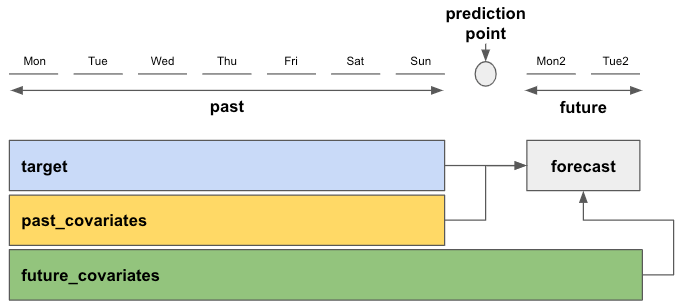

In [16]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr


df_hour = pd.DataFrame(data=np.float32((df.index.hour.values + df.index.minute.values/59)/24),
                        #normalize inequality 0 <= (hour + min/59)/24 <= 1
                       index = df.index,
                       columns = ['hour'])
hour = dts.timeseries.TimeSeries.from_series(df_hour) # convert to darts timeseries

#https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca

# futures covariates
future_covariates = dts.concatenate(
    [
        hour, #normalized
        # from API pandas documentation: https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html
        #dt_attr(df.index, "dayofyear", dtype=np.float32)/366,  # normalized, for seasons and thermal sensibility
        dt_attr(df.index, "weekofyear", dtype=np.float32)/52,  # normalized, for seasons and thermal sensibility
    ],
    axis="component",
)

future_covs_consumption = dts.concatenate(
    [
        future_covariates,
        dt_attr(df.index, "dayofweek", dtype=np.float32)/6
    ],
    axis="component",
)
future_covs_consumption = future_covariates.add_holidays("FR")  # for human consumption

# past covariation
past_covariates = dts.concatenate(
    [
        series_s_pressure, # could be a good candidate to explain cloudy days
        #series_s_wdspeed,
    ],
    axis="component",
)

## Plot covariates

In [17]:
px.line(future_covariates[:n_DATA].pd_dataframe())

## Time encoding
See: https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/

1. use an increment (like future_covariates)

2. use sin cosine (already implemented in encoder with cyclic)
limit: adds a variable, is hardly handled by randoms forest and gradient boosting

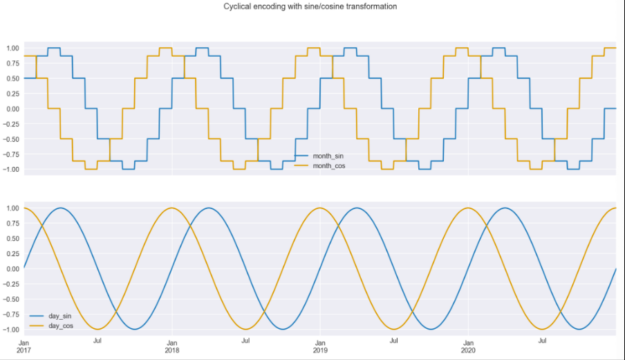

3. radial basis functions

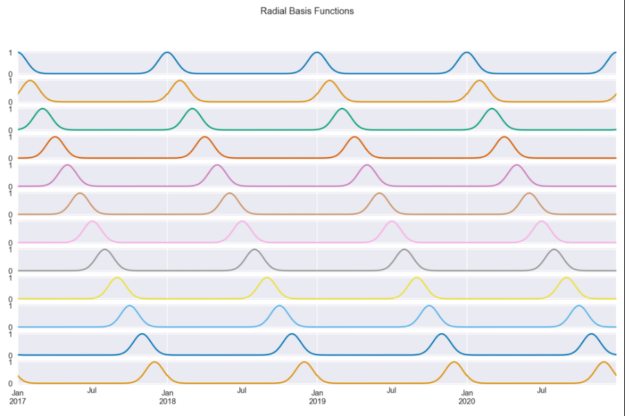

In [18]:
#time covariates
encoders = {
    #"datetime_attribute": {"future": ['hour', 'weekofyear']},
    'cyclic': {"past": ['hour', 'weekofyear']},
    "transformer": Scaler()}

In [19]:
## concatenate a multivariate
## To predict two or more variables in same time
#multivar_ghi = dts.concatenate([series_s_ghi, series_s_temp], axis=1)

In [20]:
stack = pd.concat([future_covariates.pd_dataframe(), series_s_temp.pd_dataframe(), series_s_ghi.pd_dataframe(), series_s_pressure.pd_dataframe(), series_s_water.pd_dataframe(), series_s_wddir.pd_dataframe(), series_s_wdspeed.pd_dataframe()], axis=1)
fig = px.imshow(stack.corr())#.between_time('9:00','16:00')
fig.show()


# Time series analysis

In [21]:
## acf
#from darts.utils.statistics import plot_acf, check_seasonality, plot_pacf
#plot_acf(series_s_ghi, m=N_DAY, alpha=0.05, max_lag=N_DAY*3)
#plot_pacf(series_s_ghi, m=N_DAY, alpha=0.05, max_lag=N_DAY*3)
#check_seasonality(series_ghi, m=N_DAY, alpha=0.05, max_lag=N_DAY*3)

# Model splitting
=> Keep a generalizable model

Separate into training, validation and test datasets. Training is used for learning, validation to verify that the model can be generalized to other data and testing to verify that the model works correctly on data not yet seen.
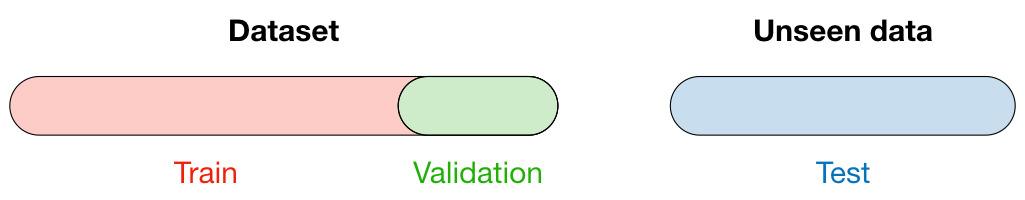

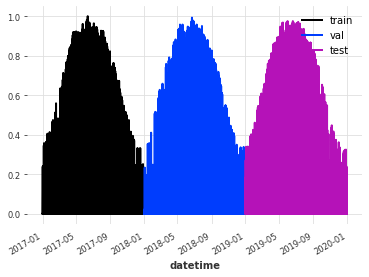

In [22]:
## use train test dateset
#train, test = series_s_ghi.split_before(2./3.) #basic split into two dataset

#use train test validation dataset to avoid overfitting

train = series_s_ghi[:n_DATA]
val = series_s_ghi[n_DATA:n_DATA*2]
test = series_s_ghi[n_DATA*2:n_DATA*3]

train.plot(label="train")
val.plot(label="val")
test.plot(label="test")

# Machine learning
Generic configuration for machine learning models with:
- Early stop to avoid over fitting
- GPU activation
- The use of optuna to find the hyper parameters

### Early stop callback

you have to set enough epochs so that the model minimizes the bias, but not too much so that the model correctly predicts datasets not yet seen. In practice, set good parameters on EarlyStopping()

Seee why: https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/

See how: https://unit8co.github.io/darts/userguide/torch_forecasting_models.html#early-stop

How to solve: https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-machine-learning-tips-and-tricks#diagnostics

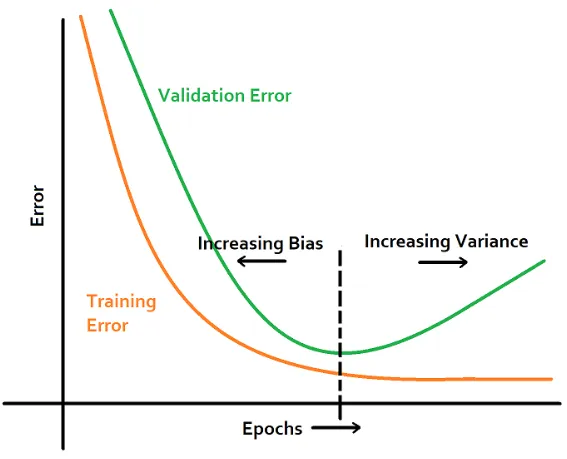

In [23]:
import torch
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning.callbacks import EarlyStopping
from darts.utils.likelihood_models import GaussianLikelihood

#how to choose metric? https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27
from darts.metrics import smape #Symmetric Mean Absolute Percentage Error
from darts.metrics import rmse #root mean square error
metric = smape

# throughout training we'll monitor the validation loss for both pruning and early stopping
#pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=3, verbose=True)
num_workers = 0

# detect if a GPU is available
#GPU: https://unit8co.github.io/darts/userguide/gpu_and_tpu_usage.html
if torch.cuda.is_available():
    print("GPU")
    pl_trainer_kwargs = {
          "accelerator": "gpu",# "devices": -1, "auto_select_gpus": True,
          "devices": [0],
          "callbacks": [early_stopper]
    }
    num_workers = 2
else:
    print("CPU")
    pl_trainer_kwargs = {
        "callbacks": [early_stopper]
        }
    num_workers = 4
    #map_location=torch.device('cpu')

GPU


# TCN
## Hyper parameters optimization

it is possible to try several covariates: https://stackoverflow.com/questions/73388133/is-there-a-way-for-optuna-suggest-categoricalto-return-multiple-choices-from-l

**TODO**:
* understand what the parameters are related to
* encode time with encoder and radial basis function, then compare

In [24]:
##hyper parameters optimization with early stop
## code inspired from: https://unit8co.github.io/darts/userguide/hyperparameter_optimization.html
#
#from darts.models import TCNModel
#
##TODO for Adrien, cross validation : https://optuna.readthedocs.io/en/stable/reference/generated/optuna.integration.OptunaSearchCV.html
## define objective function
#def objective(trial):
#    # select input and output chunk lengths
#    in_len = trial.suggest_int("in_len", 3, 10)
#
#    # Other hyperparameters
#    kernel_size = trial.suggest_int("kernel_size", 2, 5)
#    num_filters = trial.suggest_int("num_filters", 1, 5)
#    weight_norm = trial.suggest_categorical("weight_norm", [False, True])
#    dilation_base = trial.suggest_int("dilation_base", 2, 4)
#    dropout = trial.suggest_float("dropout", 0.0, 0.4)
#    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
#    #include_time = trial.suggest_categorical("time", [False, True])
#
#    # throughout training we'll monitor the validation loss for both pruning and early stopping
#    pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
#    callbacks = [pruner, early_stopper]
#    
#    ## optionally also add the (scaled) year value as a past covariate
#    #if include_time:
#    #    encoders = {
#    #        #"datetime_attribute": {"future": ['hour', 'weekofyear']},
#    #        'cyclic': {"past": ['hour', 'weekofyear']},
#    #        "transformer": Scaler()}
#    #else:
#    #    encoders = None
#
#    # reproducibility
#    #torch.manual_seed(42)
#
#    # build the TCN model
#    model = TCNModel(
#        input_chunk_length = N_DAY * in_len,
#        output_chunk_length = N_DAY * 2,
#        batch_size=64,
#        n_epochs=100,
#        nr_epochs_val_period=1,
#        kernel_size=kernel_size,
#        num_filters=num_filters,
#        weight_norm=weight_norm,
#        dilation_base=dilation_base,
#        dropout=dropout,
#        optimizer_kwargs={"lr": lr},
#        add_encoders=encoders,
#        likelihood=GaussianLikelihood(),
#        pl_trainer_kwargs=pl_trainer_kwargs,
#        model_name="tcn_model",
#        force_reset=True,
#        save_checkpoints=True,
#        work_dir=WORK_DIR,
#        show_warnings=True,
#        log_tensorboard=True, #https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html
#    )
#
#    # when validating during training, we can use a slightly longer validation
#    # set which also contains the first input_chunk_length time steps
#    #model_val_set = scaler.transform(series[-(VAL_LEN + in_len) :])
#
#    # train the model
#    model.fit(
#        series=train,
#        val_series=val,
#        num_loader_workers=num_workers,
#        #future_covariates=future_covariates,
#        #past_covariates=future_covariates,
#    )
#
#    # reload best model over course of training
#    model = TCNModel.load_from_checkpoint(WORK_DIR + "tcn_model")
#
#    # Evaluate how good it is on the validation set, using metric
#    preds = model.predict(
#        series=train,
#        n=n_DATA,
#        #future_covariates=future_covariates,
#        #past_covariates=future_covariates,
#        )
#    metrics = metric(val, preds, n_jobs=-1, verbose=True)
#    metric_val = np.mean(metrics)
#
#    return metric_val if metric_val != np.nan else float("inf")
#
#
## for convenience, print some optimization trials information
#def print_callback(study, trial):
#    print(f"Current value: {trial.value}, Current params: {trial.params}")
#    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")
#
#
## optimize hyperparameters by minimizing the metric on the validation set
#study = optuna.create_study(direction="minimize")
#study.optimize(objective, n_trials=100, callbacks=[print_callback])
#
##save best parameters to text file
#with open(WORK_DIR + "tcn_parameters.txt", "w") as text_file:
#  text_file.write(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")
#
##optuna.visualization.plot_optimization_history(study)
##study.best_trial.save(WORK_DIR + "tcn.pkl")

### Implement and use parameters found from hyper optimization

* sMAPE

Best value: 146.54126167297363, Best params: {'in_len': 8, 'kernel_size': 4, 'num_filters': 4, 'weight_norm': True, 'dilation_base': 2, 'dropout': 0.3007869621722357, 'lr': 0.00032588390944768655}

Best value: 146.50543928146362, Best params: {'in_len': 10, 'kernel_size': 3, 'num_filters': 4, 'weight_norm': False, 'dilation_base': 3, 'dropout': 0.09354574033384853, 'lr': 0.00045913023827951377, 'year': True}

* RMSE

Best value: 0.2739853858947754, Best params: {'in_len': 6, 'kernel_size': 4, 'num_filters': 1, 'weight_norm': True, 'dilation_base': 2, 'dropout': 0.1572178951208449, 'lr': 0.0008650215167068341}

Best value: 0.21035461127758026, Best params: {'in_len': 4, 'kernel_size': 5, 'num_filters': 4, 'weight_norm': True, 'dilation_base': 3, 'dropout': 0.10351718985744217, 'lr': 0.00011686155560863685}

Best value: 0.19362369179725647, Best params: {'in_len': 5, 'kernel_size': 3, 'num_filters': 5, 'weight_norm': True, 'dilation_base': 4, 'dropout': 0.2121907180378008, 'lr': 0.00017736870307334893}

In [25]:
from darts.models import TCNModel

tcn_model = TCNModel(
    input_chunk_length = N_DAY * 5,
    output_chunk_length = N_DAY * 2,
    kernel_size=3,
    weight_norm=True,
    dilation_base=4,
    batch_size=64,
    n_epochs=100,
    nr_epochs_val_period=1,
    num_filters=5,
    dropout=0.2121907180378008,
    optimizer_kwargs={"lr": 0.00017736870307334893},
    add_encoders={
        'cyclic': {"future": ['hour', 'weekofyear']},
        "transformer": Scaler()},
    likelihood=GaussianLikelihood(),
    pl_trainer_kwargs=pl_trainer_kwargs,
    model_name="tcn_model",
    force_reset=True,
    save_checkpoints=True,
    work_dir=WORK_DIR,
    show_warnings=True,
    log_tensorboard=True, #https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html
)

# train the model
tcn_model.fit(
    series=train,
    val_series=val,
    num_loader_workers=num_workers,
    #future_covariates=future_covariates,
    #past_covariates=future_covariates,
)
#save the model for latter
tcn_model.save(WORK_DIR + "tcn.pkl")

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Plot prediction with TCN
**TODO**
* probabilistic predictions: try with "num_samples > 1" and filter value below 0 in the dataframe
* filter values above 0 at night

```python
#to filter the values lower than 0
numpy_values[numpy_values <= 0] = 0 #"High-pass filter"
```
With num_samples=10, we generate 10 predictions. To summarize the information, we group them in the form of quantiles. For example, a quantile of 25% represents 25% of the population. A quantile of 50% represents the median value.

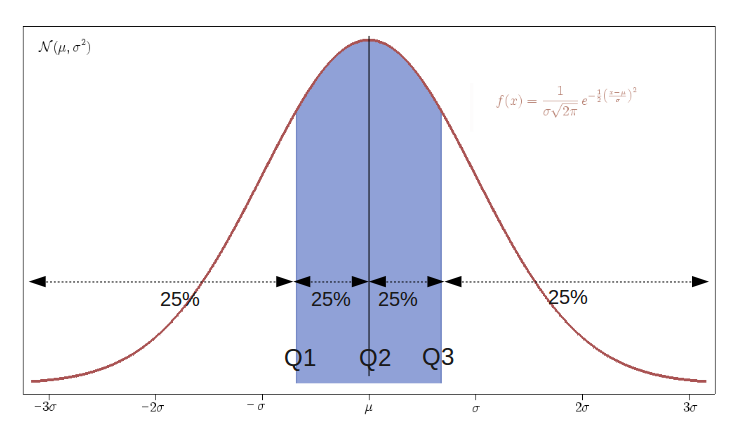

Predicting: 0it [00:00, ?it/s]

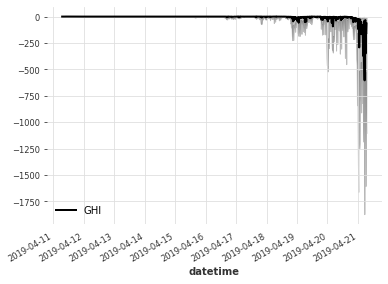

In [26]:
from darts.models import TCNModel
#load best model from disk
tcn_model = TCNModel.load(WORK_DIR + "tcn.pkl")

# make a prediction with the same covariate types
pred = tcn_model.predict(n=N_DAY*10,#n_DATA
                         num_samples=10, # >1 -> probabilistic
                         series=test[:N_DAY*1003//10], # this is only required for GFMs, //10 to start after midnight
                         #past_covariates=past_covariates,
                         #future_covariates=future_covariates
                         )

# if predictions are probabilistic/ stochastic
if pred.is_stochastic:
    GHI_pred_all = pred.pd_dataframe()
    GHI_pred = pred.quantile(0.5).pd_dataframe() # 50% of values
    GHI_pred["GHI_0.25"] = pred.quantile(0.25).pd_dataframe() # 25% of lower values
    GHI_pred["GHI_0.75"] = pred.quantile(0.75).pd_dataframe() #75% of higher values
#plot a single values
else:
    #convert to pandas dataframe to use plotly
    GHI_pred = pred.pd_dataframe()

# add column with true value
GHI_pred["GHI_mesured"] = test["GHI"][GHI_pred.index].pd_dataframe()

#use of plotly plot
fig = px.line(GHI_pred)
fig.show()

#use of darts plot
pred.plot()

## Predict multiples horizons with historical_forecasts()

In [27]:
backtest_series = tcn_model.historical_forecasts(
    series_s_ghi, #train + val + test serie
    start=n_DATA*2, #start at the begginning of test dataset
    num_samples=1,
    forecast_horizon=N_DAY*1,
    stride=N_DAY*1, #lenght of the time windows
    last_points_only=False, #True = single serie
    retrain=False, #don't retrain model
    #verbose=True,
)

# Others covariates
**TODO**
* use *Sun Ephemeris Tours* as futures covariates 

# Others models

**TODO**

* compare with TFT: https://unit8co.github.io/darts/examples/13-TFT-examples.html
* compare with LightGBM https://unit8co.github.io/darts/generated_api/darts.models.forecasting.lgbm.html?highlight=lightgbmmodel